In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import amfe
from pyfeti import utils, feti_solver
from amfe.contact import jenkins, Nonlinear_force_assembler, Create_node2node_force_object
import time
import scipy.sparse as sparse
import scipy
import sparse as sp
from scipy.optimize import minimize, root
from contpy import optimize as copt, frequency
import numdifftools as nd

def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using python in global path


In [2]:
# geometric properties
dimension= 2
width= 5.0
heigh = 1.0
init_gap_x = width - 0.2*width
init_gap_y = -heigh - 0.01*heigh


#mesh properties
#x_divisions,y_divisions= 51,21
x_divisions,y_divisions= 21,6


#-------------------------------------------------------------------------------------------------------------------------
# Creating mesh for 2 bodies
d1= utils.DomainCreator(width=width, heigh=heigh, 
                         x_divisions=x_divisions, y_divisions=y_divisions, 
                         domain_id=1, start_x=0.0, start_y=0.0)

mesh_file_1 = 'domain_1.msh'
d1.save_gmsh_file(mesh_file_1)
m = amfe.Mesh()
m.import_msh(mesh_file_1)


m1 = m.translation(np.array([0., 0.]))
m2 = m.translation(np.array([init_gap_x,init_gap_y]))


<IPython.core.display.Javascript object>


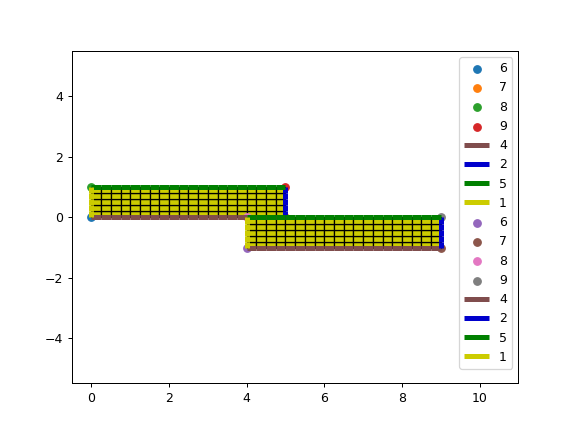

In [3]:
fig1, ax1 = plt.subplots(1,1)
ax1 = amfe.plot2Dmesh(m1,ax=ax1)
amfe.plot2Dmesh(m2,ax=ax1)
ax1.set_xlim([-0.5 ,2.2*width])
ax1.set_ylim([-1.1*width,1.1*width])
#ax1.legend('off')
plt.show()

In [4]:
# Defining contact pairs
m1.split_in_groups()
m2.split_in_groups()


tol_radius = 1.1E-1
contact_12_tag = 4
contact_21_tag = 5

# contact pair 12
d1 = m1.get_submesh('phys_group',contact_12_tag)
d2 = m2.get_submesh('phys_group',contact_21_tag)

contact12 = amfe.contact.Contact(d1,d2,tol_radius=tol_radius)
print('Number of contact pairs = %i' %len(contact12.contact_elem_dict))

It was not possible to find a slave node for master node 0. Minimum distance is 4.000012e+00
It was not possible to find a slave node for master node 1. Minimum distance is 3.750013e+00
It was not possible to find a slave node for master node 2. Minimum distance is 3.500014e+00
It was not possible to find a slave node for master node 3. Minimum distance is 3.250015e+00
It was not possible to find a slave node for master node 4. Minimum distance is 3.000017e+00
It was not possible to find a slave node for master node 5. Minimum distance is 2.750018e+00
It was not possible to find a slave node for master node 6. Minimum distance is 2.500020e+00
It was not possible to find a slave node for master node 7. Minimum distance is 2.250022e+00
It was not possible to find a slave node for master node 8. Minimum distance is 2.000025e+00
It was not possible to find a slave node for master node 9. Minimum distance is 1.750029e+00
It was not possible to find a slave node for master node 10. Minimum d

In [5]:
contact12

In [6]:
contact12.master_normal_dict

{16: array([0., 1., 0.]),
 17: array([0., 1., 0.]),
 18: array([0., 1., 0.]),
 19: array([0., 1., 0.]),
 20: array([0., 1., 0.])}

In [7]:
rho = 7.85E-9 # ton/mm
E = 2.10E5 # MPa = N/mm2
my_material_template = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)

component_dict = {1:{'mesh' : m1, 
                     'domain_tag':3,
                     'external_force_tag':2,
                     'external_force_direction':1,
                     'force_value':1.0,
                     'Dirichlet_tag':1,
                     'material' : my_material_template},
                   2:{'mesh': m2, 
                      'domain_tag':3,
                      'external_force_tag':1,
                      'external_force_direction':0,
                      'force_value':0,
                       'Dirichlet_tag':2,
                       'material' : my_material_template}}


ro=1.0E7
N0=0.0E0
k= 1.0E0
mu= 0.0
contact_dict = {'12' : {'contact' : contact12, 
                        'contact_pair_id' : (1,2),
                        'elem_type' : 'jenkins' , 
                        'elem_properties' : {'ro':ro,'N0':N0,'k':k, 'mu':mu}}}

In [8]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager


class ComponentsAssembler():
    def __init__(self,component_dict,dimension=3):
        self.component_dict = component_dict
        self.dimension = dimension
        self.selection_dict = {}
        self.K_dict = {}
        self.M_dict = {}
        self.f_dict ={}
        self.dof_manager_dict = {}
        # call internal routine
        self.create_selection_dict()
       
    
    def create_selection_dict(self):
        dimension = self.dimension
        
        for domain_id, param_dict in component_dict.items():

            globals().update(param_dict)
            #print(param_dict)
            #print(locals())
            m = mesh 
            my_comp = amfe.MechanicalSystem()
            my_comp.set_mesh_obj(m)
            my_comp.set_domain(domain_tag,material)

            if dimension==3:

                if external_force_direction == 0:
                    direction = np.array([1.,0.,0.])
                elif external_force_direction == 1:
                    direction = np.array([0.,1.,0.])
                else:
                    direction = np.array([0.,0.,1.])

            elif dimension==2:
                if external_force_direction == 0:
                    direction = np.array([1.,0.])
                elif external_force_direction == 1:
                    direction = np.array([0.,1.])


            my_comp.apply_neumann_boundaries(external_force_tag,force_value,direction)
            print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)

            K, f_ = my_comp.assembly_class.assemble_k_and_f()
            _, fext = my_comp.assembly_class.assemble_k_and_f_neumann()
            M = my_comp.assembly_class.assemble_m()
            
            self.K_dict[domain_id] = K 
            self.M_dict[domain_id] = M
            self.f_dict[domain_id] = fext

            try:
                connectivity = []
                for _,item in m.el_df.iloc[:, m.node_idx:].iterrows():
                    connectivity.append(list(item.dropna().astype(dtype='int64')))
                m.el_df['connectivity'] = connectivity
            except:
                pass

            id_matrix = my_comp.assembly_class.id_matrix
            id_map_df = dict2dfmap(id_matrix)
            self.dof_manager_dict[domain_id] = DofManager(m.el_df,id_map_df,tag='phys_group')
            s = create_selection_operator(id_map_df,m.el_df)
            self.selection_dict[domain_id] = s


    
    def components2list(self):
        component_dict = self.component_dict
        dimension = self.dimension
        
        K_list = []
        M_list = []
        f_list = []
        for domain_id, param_dict in component_dict.items():
            
            globals().update(param_dict)
            s = self.selection_dict[domain_id]
            K = self.K_dict[domain_id]
            M = self.M_dict[domain_id]
            fext = self.f_dict[domain_id] 

            from pyfeti.src.linalg import Matrix
            K1 = Matrix(K,key_dict=s.selection_dict)
            M1 = Matrix(M,key_dict=s.selection_dict)


            # applying Dirichlet B.C.
            print('K1.max() = ', K1.data.max())
            K1.eliminate_by_identity(Dirichlet_tag,K1.data.max())
            M1.eliminate_by_identity(Dirichlet_tag,0.0)

            K_list.append(K1.data)
            M_list.append(M1.data)
            f_list.append(fext)
            
            self.K_dict[domain_id] = K1.data
            #self.M_dict[domain_id] = M1.data
            #self.f_dict[domain_id] = fext
            
        return K_list, M_list, f_list
    
def list2global(K_list, M_list, f_list, alpha=1.0E-3, beta=1.0E-7):
   
    K_global = sparse.block_diag(K_list)
    M_global = sparse.block_diag(M_list)
    
    C_global = alpha*K_global + beta*M_global
    f_global = np.concatenate(f_list)
    f_global/=np.linalg.norm(f_global)

    return K_global.tocsc(),M_global.tocsc(),C_global.tocsc(),f_global


def create_map_local_domain_dofs_dimension(component_dict,dimension=3):
    map_local_domain_dofs_dimension = {}
    for domain_id, param_dict in component_dict.items():
        m_ = param_dict['mesh']
        map_local_domain_dofs_dimension[domain_id] = m_.no_of_nodes*dimension
    return map_local_domain_dofs_dimension

class SplitOperator():
    def __init__(self,map_local_domain_dofs_dimension):
        self.map_local_domain_dofs_dimension = map_local_domain_dofs_dimension
        
    def LinearOperator(self,u):
        u_list = []
        idx = 0
        for key, item in self.map_local_domain_dofs_dimension.items():
            try:
                u_list.append(u[idx:idx+item])
            except:
                u_list.append(u[idx:])
            idx = item
        return u_list
        
class Nonlinear_Force():
    def __init__(self,Fnl_obj_list):
        self.Fnl_obj_list = Fnl_obj_list
        
    def compute_force(self,u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.compute(u,X0)
            except:
                output = fnl_obj_item.compute(u,X0)

        return output
        
    def compute_jacobian(self,u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.Jacobian(u,X0)
            except:
                output = fnl_obj_item.Jacobian(u,X0)

        return output
    
    
class Nonlinear_Force_gap():
    def __init__(self,Fnl_obj_list):
        self.Fnl_obj_list = Fnl_obj_list
        
    def compute_force(self,gap_u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.compute(gap_u,X0)
            except:
                output = fnl_obj_item.compute(gap_u,X0)

        return output
        
    def compute_jacobian(self,gap_u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.Jacobian(gap_u,X0)
            except:
                output = fnl_obj_item.Jacobian(gap_u,X0)

        return output
    
    
def local_compute_force(global_force,gap_u,X0,map_dict,contact_list):
    local_force_list = []
    i=0
    dim = 3
    for key,global_index in map_dict.items():
        local_force = contact_list[key].compute(gap_u[range(i,i+dim)],X0[global_index])
        local_force_list.append(local_force)
        i+=1
    return np.array(local_force_list)
    
def force_in_time(fext,time_points,omega):
    
    f_list = []
    for i in range(time_points):
        a = rate*np.sin(2.0*np.pi*i/time_points)
        f1 = a*fext
        f_list.append(f1)

    return np.array(f_list).T

In [9]:
'''
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s1 = create_selection_operator(id_map_df,m1.el_df)

neighbors_dict = {}
neighbors_dict['right'] = 2
neighbors_dict['left'] = 1
neighbors_dict['top'] = 5
neighbors_dict['bottom'] = 4
neighbors_dict['bottom_left_corner'] = 6
neighbors_dict['bottom_right_corner'] = 7
neighbors_dict['top_left_corner'] = 8
neighbors_dict['top_right_corner'] = 9

B_local_dict = {}
for key, value in neighbors_dict.items():
    B_local_dict[key] = s.build_B(value)
'''

"\nid_matrix = my_system1.assembly_class.id_matrix\nid_map_df = dict2dfmap(id_matrix)\ns1 = create_selection_operator(id_map_df,m1.el_df)\n\nneighbors_dict = {}\nneighbors_dict['right'] = 2\nneighbors_dict['left'] = 1\nneighbors_dict['top'] = 5\nneighbors_dict['bottom'] = 4\nneighbors_dict['bottom_left_corner'] = 6\nneighbors_dict['bottom_right_corner'] = 7\nneighbors_dict['top_left_corner'] = 8\nneighbors_dict['top_right_corner'] = 9\n\nB_local_dict = {}\nfor key, value in neighbors_dict.items():\n    B_local_dict[key] = s.build_B(value)\n"

In [10]:
comp_assembler = ComponentsAssembler(component_dict,dimension=2)
K_list, M_list, f_list = comp_assembler.components2list()

K_global,M_global,C_global,f_global =  list2global(K_list, M_list, f_list,alpha = 1.0E-2, beta = 1.0E-4)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Number of nodes is equal to 126
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Number of nodes is equal to 126
K1.max() =  557307.6923076926
K1.max() =  557307.6923076926


/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


In [11]:
comp_assembler.selection_dict

{1: <pyfeti.src.utils.SelectionOperator at 0x7fa86e599610>,
 2: <pyfeti.src.utils.SelectionOperator at 0x7fa86e5cc090>}

In [12]:
s1 = comp_assembler.selection_dict[1]

In [13]:
d1 = comp_assembler.dof_manager_dict[1]

In [14]:
contact12.master_nodes

[16, 17, 18, 19, 20]

In [15]:
contact12.slaves_nodes

[105, 106, 107, 108, 109]

<IPython.core.display.Javascript object>


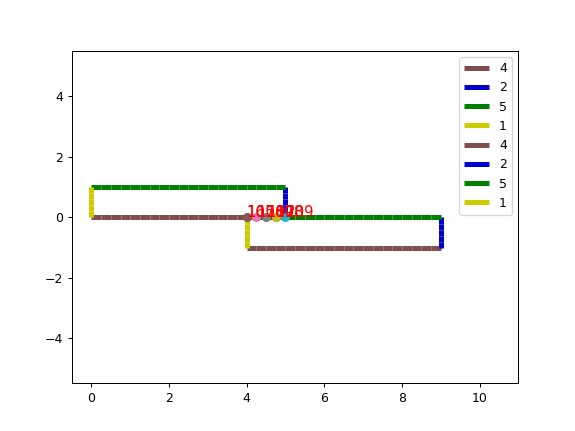

In [16]:
fig2, ax12 = plt.subplots(1,1)
amfe.plot2Dnode_id(m1,contact12.master_nodes,plot_nodeid=True, ax = ax12)
amfe.plot2Dnode_id(m2,contact12.slaves_nodes,plot_nodeid=True,ax = ax12)
amfe.plot2Dmesh(m1,ax=ax12)
amfe.plot2Dmesh(m2,ax=ax12)

ax12.set_xlim([-0.5 ,2.2*width])
ax12.set_ylim([-1.1*width,1.1*width])
#ax1.legend('off')
plt.show()

In [17]:
domain_id = 1
rows = comp_assembler.dof_manager_dict[domain_id].get_dofs_from_node_list(contact12.master_nodes)
contact_dofs = len(rows)
ndofs_1 = comp_assembler.K_dict[domain_id].shape[0]
cols = list(range(contact_dofs))
ones = np.ones(contact_dofs)
B12 = sparse.coo_matrix((ones,(cols,rows)),shape=(contact_dofs,ndofs_1))

<IPython.core.display.Javascript object>


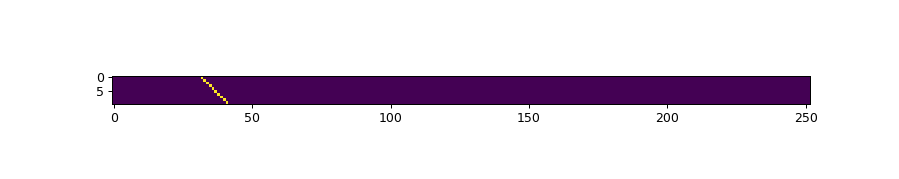

In [18]:
plt.figure(figsize=(10,2))
plt.imshow(B12.A)
plt.show()

In [19]:
domain_id = 2
rows = comp_assembler.dof_manager_dict[domain_id].get_dofs_from_node_list(contact12.slaves_nodes)
contact_dofs = len(rows)
ndofs_1 = comp_assembler.K_dict[domain_id].shape[0]
cols = list(range(contact_dofs))
ones = -1.0*np.ones(contact_dofs)
B21 = sparse.coo_matrix((ones,(cols,rows)),shape=(contact_dofs,ndofs_1))

<IPython.core.display.Javascript object>


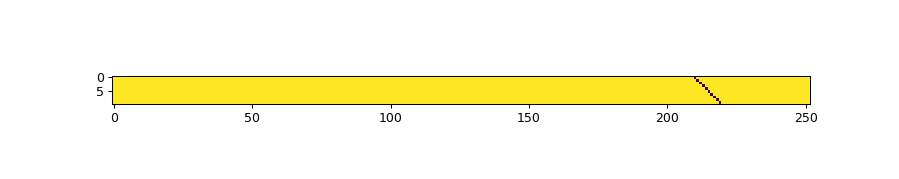

In [20]:
plt.figure(figsize=(10,2))
plt.imshow(B21.A)
plt.show()

In [21]:
B_dict = {}
B_dict[1] = {}
B_dict[2] = {}
B_dict[1][1,2] = B12
B_dict[2][2,1] = B21
K_dict = comp_assembler.K_dict
M_dict = comp_assembler.M_dict
f_dict = comp_assembler.f_dict
feti_solver_obj = feti_solver.SerialFETIsolver(K_dict,B_dict,f_dict)
feti_solver_obj_M = feti_solver.SerialFETIsolver(M_dict,B_dict,f_dict)
manager = feti_solver_obj.manager

In [22]:
B = feti_solver_obj.manager.assemble_global_B()

<IPython.core.display.Javascript object>


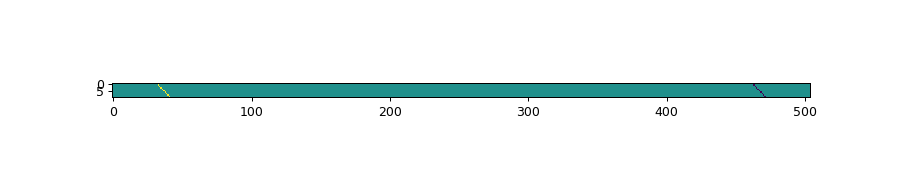

In [23]:
plt.figure(figsize=(10,2))
plt.imshow(B.A)
plt.show()

In [24]:
M, f_global = feti_solver_obj_M.manager.assemble_global_K_and_f()
def system_without_projection(u,tol=1.0e-6):
    
    f = M_global.dot(u)
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = feti_solver.SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    return solution_obj.displacement
    
#un = system_without_projection(u0)
D_wp = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system_without_projection(x))

In [25]:
#modes = K_global.shape[0] - 2
modes = 40
val, Phi = sparse.linalg.eigs(D_wp,k=modes)
Phi = Phi.real
normalizeit = False
if normalizeit:
    for i in range(modes):
        vi = Phi[:,i]
        Phi[:,i] = vi/np.linalg.norm(vi)  

In [26]:
val

array([6.40032423e-08+0.j, 7.14520216e-10+0.j, 1.09555774e-10+0.j,
       5.58571070e-13+0.j, 2.09627285e-13+0.j, 8.58885094e-14+0.j,
       8.29911119e-14+0.j, 4.20036390e-14+0.j, 3.76849401e-14+0.j,
       3.25998939e-14+0.j, 2.92016600e-14+0.j, 1.83313114e-14+0.j,
       1.75654201e-14+0.j, 1.70680648e-14+0.j, 1.35103934e-14+0.j,
       1.20758042e-14+0.j, 1.16279684e-14+0.j, 1.06781907e-14+0.j,
       8.68821631e-15+0.j, 8.15012244e-15+0.j, 7.91628126e-15+0.j,
       7.25282215e-15+0.j, 7.22579556e-15+0.j, 7.02941874e-15+0.j,
       6.20596496e-15+0.j, 5.83262452e-15+0.j, 5.46003566e-15+0.j,
       5.38247886e-15+0.j, 4.97258287e-15+0.j, 4.72484930e-15+0.j,
       4.56320251e-15+0.j, 4.45511594e-15+0.j, 4.01598744e-15+0.j,
       3.89920427e-15+0.j, 3.78014584e-15+0.j, 3.72348521e-15+0.j,
       3.44689059e-15+0.j, 3.37543978e-15+0.j, 3.18310124e-15+0.j,
       3.17378963e-15+0.j])

In [27]:
map_local_domain_dofs_dimension = create_map_local_domain_dofs_dimension(component_dict,dimension=2)
SO = SplitOperator(map_local_domain_dofs_dimension)

<IPython.core.display.Javascript object>


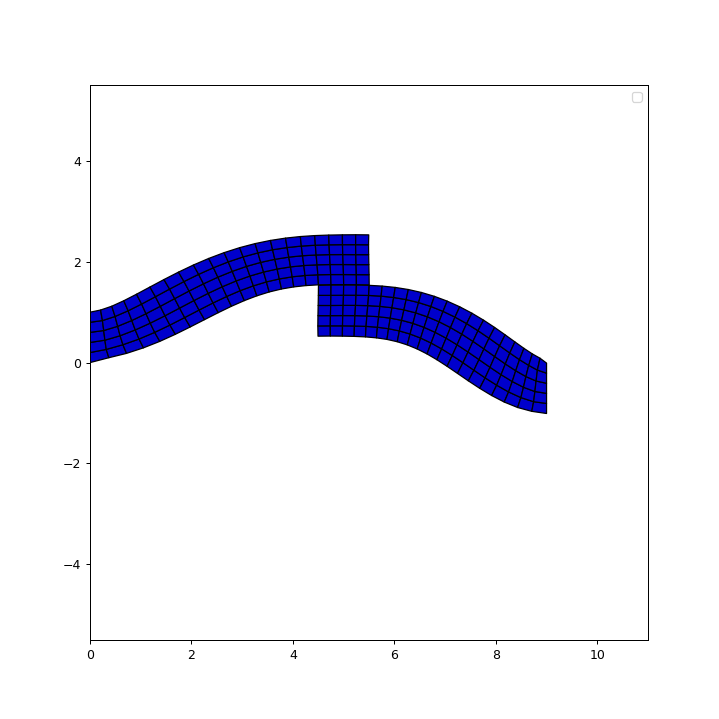

In [28]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(Phi[:,0])
fig, ax2 = plt.subplots(1,1, figsize=(8,8))

mesh_list = [m1,m2]
factor=6.0
def update(factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i],factor=factor,ax=ax2,color_id=1)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
frame_list = list(map(lambda x : 20.0*np.sin(2.0*np.pi*x/100),range(100)))
anim = animation.FuncAnimation(fig, update,
                               frames=frame_list, interval=20)
plt.show()

<IPython.core.display.Javascript object>


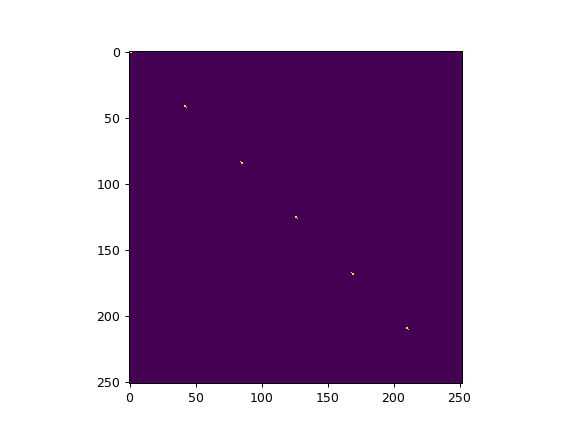

In [29]:
plt.figure()
plt.imshow(K_dict[1].A)
plt.show()

In [30]:
# solving Eigenvalue problem for problem change of basis
K_global_inv = sparse.linalg.splu(K_global)
D = sparse.linalg.LinearOperator(shape=K_global.shape, matvec = lambda x : K_global_inv.solve(M_global.dot(x)))

#modes = K_global.shape[0] - 2
modes = 20
val, Phi = sparse.linalg.eigs(D,k=modes)
Phi = Phi.real
normalizeit = True
if normalizeit:
    for i in range(modes):
        vi = Phi[:,i]
        Phi[:,i] = vi/np.linalg.norm(vi)  

<IPython.core.display.Javascript object>


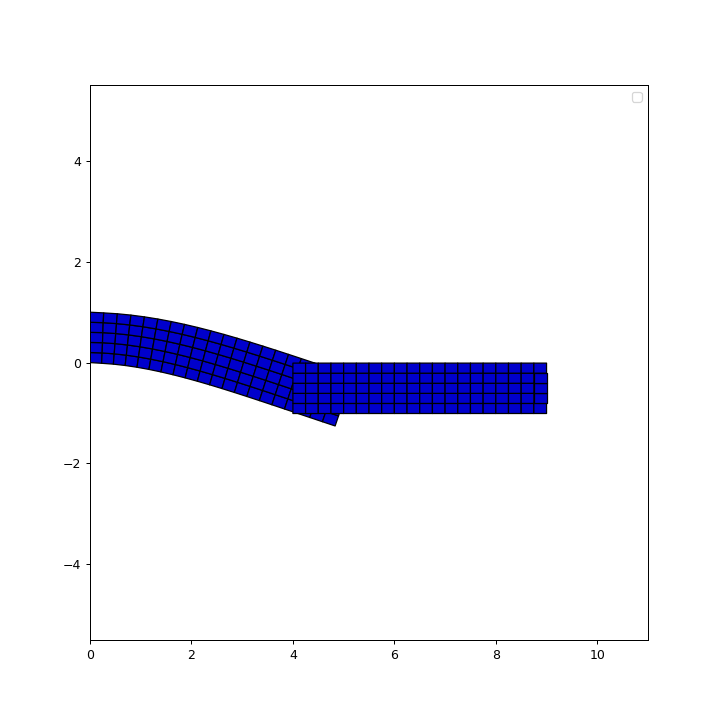

In [32]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(Phi[:,1])
fig, ax2 = plt.subplots(1,1, figsize=(8,8))

mesh_list = [m1,m2]
factor=6.0
def update(factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i],factor=factor,ax=ax2,color_id=1)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
frame_list = list(map(lambda x : 20.0*np.sin(2.0*np.pi*x/100),range(100)))
anim = animation.FuncAnimation(fig, update,
                               frames=frame_list, interval=20)
plt.show()

In [ ]:
def H(x):
    if x>=0.0:
        return 1.0
    else:
        return 0.0

def H2(x):
    alpha = 0.3
    return 1.0/(1.0+np.exp(-alpha*x))
    
def Ramp(x):
    return x*H(x)
    

def nonlinear(delta_u, gap0=0.0):
    force = np.zeros(delta_u.shape)
    for i,local_delta_u in enumerate(delta_u):
        local_delta_u -= gap0
        force[i] =  penalty_parameter*Ramp(local_delta_u)
        
    return force

In [ ]:
Fnl_obj_list = []
for contact_key,contact_item in contact_dict.items():
    bodies_contact_id = contact_item['contact_pair_id']
    contact_12 = contact_item['contact']
    elem_type = contact_item['elem_type']
    elem_properties = contact_item['elem_properties']
    create_obj_1 = Create_node2node_force_object(contact12,bodies_contact_id,elem_type,elem_properties,dimension,map_local_domain_dofs_dimension)
    Fnl_obj_list.append(create_obj_1.assemble_nonlinear_force())
    

In [ ]:
from contpy import optimize as copt, frequency, operators

nH = 2
omega = 1.0
time_points = nH*25
rate = 1.0E2

ndofs = K_global.shape[0]
Q = frequency.assemble_hbm_operator(ndofs,number_of_harm=nH ,n_points=time_points) # bases of truncaded Fourier
nonlinear_force_obj = Nonlinear_Force(Fnl_obj_list)
AFT  = operators.Nonlinear_Force_AFT(Q,nonlinear_force_obj)
Z = lambda w : frequency.create_Z_matrix(K_global,C_global,M_global,f0= w/(2.0*np.pi),nH=nH, static=False)
Zw = Z(omega)
Zw_real = copt.complex_matrix_to_real_block(Zw)
force_global_in_time = force_in_time(f_global,time_points,omega)
force_global_ = Q.H.dot(force_global_in_time)

In [ ]:
def Residual_and_Jac_in_real_block(u_real):
    u_ = copt.real_array_to_complex(u_real)
    fnl_complex_eval, Jnl_eval_1, Jnl_eval_conj_1 = AFT.compute_force_and_jac(u_)
    J_block_real = copt.complex_matrix_to_real_block(Jnl_eval_1, Jnl_eval_conj_1)
    J = Zw_real - J_block_real
    R = Zw.dot(u_) - force_global_ - fnl_complex_eval
    R_real = copt.complex_array_to_real(R)
    return R_real, J
    
    

In [ ]:
Zw_inv = sparse.linalg.splu(Zw)
u__initial = Zw_inv.solve(force_global_)
u__inital_real = copt.complex_array_to_real(u__initial)
u__inital_real = 0.0*u__inital_real

In [ ]:
class LM_Krylov(copt.LinearSolver):
    def __init__(self,x0,tol=1.0E-6,maxiter=50,verbose=False):
        self.tol = tol
        self.maxiter = maxiter
        self.verbose = verbose
        self.x0 = x0
        self._counter = 0
        self.max_reuse_precond = 10
        self.M = None
        self.info = 0
        super().__init__(**self.__dict__)
        
    def solve(self,A,b):
        
        if self._counter ==0:
            if self.verbose:
                print('Computing exact preconditioner')
            LU = sparse.linalg.splu(A)
            self.M = sparse.linalg.LinearOperator(shape=A.shape,matvec = lambda x : LU.solve(x))
            self._counter +=1
        elif self._counter==self.max_reuse_precond:
            self._counter = 0
        else:
            self._counter +=1
            
        x, self.info = sparse.linalg.gmres(A, b, x0=self.x0, tol=self.tol,maxiter=self.maxiter,M=self.M,  restart=self.max_reuse_precond)
        
        if self.verbose:
            print('GMRes info - %i' %self.info)
            
        if self.info!=0:
            self._counter = 0
            x = self.solve(A,b)
            
        return x
        
    def update(self,xn):
        if self.info==0:
            self.x0 = xn
        #self.maxiter += 2
        
   

class LM_CG_Krylov(copt.LinearSolver):
    def __init__(self,x0,tol=1.0E-6,maxiter=50,verbose=False):
        self.tol = tol
        self.maxiter = maxiter
        self.verbose = verbose
        self.x0 = x0
        self._counter = 0
        self.max_reuse_precond = 10
        self.M = None
        self.info = 0
        super().__init__(**self.__dict__)
        
    def solve(self,A,b):
        
        if self._counter ==0:
            if self.verbose:
                print('Computing exact preconditioner')
            LU = sparse.linalg.splu(A)
            self.M = sparse.linalg.LinearOperator(shape=A.shape,matvec = lambda x : LU.solve(x))
            self._counter +=1
        elif self._counter==self.max_reuse_precond:
            self._counter = 0
        else:
            self._counter +=1
            
        x, self.info = sparse.linalg.cg(A, b, x0=self.x0, tol=self.tol,maxiter=self.maxiter,M=self.M)
        
        if self.verbose:
            print('GMRes info - %i' %self.info)
            
        if self.info!=0:
            self._counter = 0
            x = self.solve(A,b)
            
        return x
        
    def update(self,xn):
        if self.info==0:
            self.x0 = xn
        #self.maxiter += 2
        

In [ ]:
sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block,0.0*u__inital_real,method=None,jac=True,maxiter=200)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
ls_obj = LM_Krylov(u__inital_real,tol=1.0E-6,maxiter=50,verbose=True)
sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block,u__inital_real,method=None,jac=True,maxiter=200, linear_solver=ls_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
ls_cg_obj = LM_CG_Krylov(u__inital_real,tol=1.0E-6,maxiter=50,verbose=True)
sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block,u__inital_real,method=None,jac=True,maxiter=200, linear_solver=ls_cg_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(u_sol_time)
fig2, ax2 = plt.subplots(1,1)

mesh_list = [m1,m2]
factor=6.0
def update_HBM(j,factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i].T[j],factor=factor,ax=ax2,color_id=2)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
anim = animation.FuncAnimation(fig2, update_HBM,
                               frames=range(time_points), interval=1)

In [ ]:
Phi.shape

In [ ]:
Zw

In [ ]:
val

In [ ]:
V_ = Phi[:,0:2]
#[V_]*nH
V= sparse.block_diag(([V_]*nH))

Zw_mode = V.T@Zw@V
Zw_mode_real = copt.complex_matrix_to_real_block(Zw_mode)
def Residual_and_Jac_mode(q_real):
    q_complex = copt.real_array_to_complex(q_real)
    u_ = V.dot(q_complex)
    fnl_complex_eval, Jnl_eval_1, Jnl_eval_conj_1 = AFT.compute_force_and_jac(u_)
    J_block_real = copt.complex_matrix_to_real_block(V.T@Jnl_eval_1@V, V.T@Jnl_eval_conj_1@V)
    J = Zw_mode_real  - J_block_real
    R = Zw.dot(u_) - force_global_ - fnl_complex_eval
    VTR = V.T.dot(R)
    R_real = copt.complex_array_to_real(VTR)
    return R_real, J

In [ ]:
Zw_mode.A

In [ ]:
q_complex_1 = V.T.dot(u_sol)
#q_complex_1 = np.linalg.solve(Zw_mode,V.T@force_global_)
#q_complex = V.T.dot(u__initial)
q_real_init_1 = copt.complex_array_to_real(q_complex_1 )
#q_real_init_2 = copt.complex_array_to_real(q_complex_2 )
sol2_q = copt.LevenbergMarquardt(Residual_and_Jac_mode,q_real_init_1,method=None,jac=True,maxiter=200,tol=1.E-8)

#u = Vq
q_sol_complex = copt.real_array_to_complex(sol2_q.x)
u_sol_mode = V.dot(q_sol_complex)
u_sol_time_ = Q.dot(u_sol_mode)

In [ ]:
q_sol_complex

In [ ]:
from matplotlib import animation, rc
u_list_ = SO.LinearOperator(u_sol_time_)
fig3, ax3 = plt.subplots(1,1)

mesh_list = [m1,m2]
factor=6.0
def update_HBM_modes(j,factor=6.0):
    i=0
    ax3.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list_[i].T[j],factor=factor,ax=ax3,color_id=3)
        i+=1

    ax3.set_xlim([0,2.2*width])
    ax3.set_ylim([-1.1*width,1.1*width])
    ax3.legend('off')
    
    
#update(10)
anim = animation.FuncAnimation(fig3, update_HBM_modes,frames=range(time_points), interval=20)

In [ ]:
fig4, (ax41, ax42) = plt.subplots(1,2, figsize=(6,6))
ax41.plot(u_sol.real,u_sol_mode.real,'o')
ax42.plot(u_sol.imag,u_sol_mode.imag,'*')
plt.show()

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(0.0*u_sol_mode)
ls_cg_obj = LM_CG_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200, linear_solver=ls_cg_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(u_sol_mode)
ls_cg_obj = LM_CG_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200, linear_solver=ls_cg_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(u_sol_mode)
ls_obj_ = LM_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200,verbose=True,linear_solver=ls_obj_)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(u_sol_mode)
ls_obj_ = LM_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.Newton(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200,verbose=True,linear_solver=ls_obj_)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
Zw.shape